In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numba import jit

In [3]:
Nx = 200
Ny = 200

lambda0 = 10.
u0 = 200.
q0 = 100.

dx = 0.1
dy = 0.1
dV = 0.01

fp = -3.
fc= 7.

Nvx = 7
Nvy = 7

@jit
def StartValue(Nvx, Nvy):

    global lambda0, u0, Nx, Ny

    u = np.zeros( ( Nx, Ny ) )
    lam = np.ones( ( Nx, Ny ) ) * lambda0
    rule = np.zeros( ( Nx, Ny ) )

    for i in np.arange( Nvx, Nx - Nvx, 1 ):

        u[ i ][ Ny - 1 ] = u0

        lam[ i ][ 0 ] = 1.0e-8

    for i in np.arange( 0, Ny, 1 ):

        u[ i ][ 0 ] = 1.0e-8

        lam[ Nx - 1 ][ i ] = q0

    for i in np.arange( 0, Nvx, 1 ):

        lam[Nx - 1 - i][Ny - 1] = 1.0e-8

        u[ Nx - i - 1 ][ 0 ] = u0

        for j in np.arange( 0, Nvy, 1 ):

            rule[int( Nx / 2 - Nvx / 2 + i)][int( Ny / 2 - Nvy / 2 + j ) ] = 0.0

            lam[int(Nx / 2 - Nvx / 2 + i)][int(Ny / 2 - Nvy / 2 + j)] = 10 ** 5

            u[int( Nx / 2 - Nvx / 2 + i )][int( Ny / 2 - Nvy / 2 + j) ] = u0

            lam[Nx - 1 - i][j] = 10 ** 5

            lam[ i ][ j ] = 1.0e-8

            lam[ Nx - 1 ][ Ny - j - 1 ] = 1.0e-8

            lam[Nx - 1 - i][Ny - 1 - j] = 1.0e-14

            rule[Nx - 1 - i][Ny - 1 - j] = 1.0e-14

            rule[i + 1][j + 1] = 0.0

    for i in np.arange( 0, Nvx - 1, 1 ):

        for j in np.arange( 0, Nvy - 1, 1 ):

            rule[ i + 1 ][ Ny - j - 1 ] = 0.0

    for i in np.arange( 0, Nvy, 1 ):

        u[ Nx - 1 ][ i ] = u0
        u[ Nvx ][ i ] = u0

    return u, lam, rule

In [4]:
@jit
def ai( n, m, p, k, lam ):

    global dV, dx, dy

    if p == 0:

        return 2. * dV / dx**2 * ( lam[ n ][ m + k ] * lam[ n ][ m ] / ( lam[ n ][ m + k ] + lam[ n ][ m ] ) )

    if k == 0:

        return 2. * dV / dy**2 * ( lam[ n + p ][ m ] * lam[ n ][ m ] / ( lam[ n + p ][ m ] + lam[ n ][ m ] ) )

In [5]:
@jit
def IterTp( n, m, u, lam, Nvx, Nvy ):

    global Nx, Ny

    global fp, fc

    global dV, q0

    global ai

    aw = ai( n, m, -1, 0, lam )

    ae = ai( n, m, 1, 0, lam )

    aa = ai( n, m, 0, 1, lam )

    an = ai( n, m, 0, -1, lam )

    uw = u[ n - 1 ][ m ]
    ue = u[ n + 1 ][ m ]
    ua = u[ n ][ m - 1 ]
    un = u[ n ][ m + 1 ]

    if n == Nx - 2 and m < Ny - Nvy:

        ap = aw + aa + an + fp *dV

        return ( aw * uw + aa * ua + an * un + fc *dV + q0 ) / ap

    elif m == Ny - Nvy - 1 and n < Nvx + 1:

        ap = aw +aa + ae + fp * dV

        return ( aw * uw + aa * ua + ae * ue + fc *dV + q0 * 4 ) / ap

    elif n == Nvx + 1 and m > Ny - Nvy - 2:

        ap = an + aa + ae + fp * dV

        return ( an * un + aa * ua + ae * ue + fc *dV + q0 * 2 ) / ap

    elif n == Nvx + 1 and m == Ny - 1 - Nvy:

        ap = aa + ae + fp *dV

        return ( aa * ua + ae * ue + fc *dV + q0 * 2 ) / ap

    else:

        ap = aw + ae + aa + an + fp * dV

        return ( aw * uw + ae * ue + aa * ua +an * un + fc * dV ) / ap

In [6]:
@jit
def Norm( A ):

    N = A.shape[ 0 ]

    Max = np.max( A )

    for i in np.arange( 0, N, 1 ):

        if np.sum( np.fabs( A[i] ) ) >= Max:

            Max = np.sum( np.fabs( A[i] ) )

    return Max

In [7]:
@jit
def Progon(u, lam, rule, Nvx, Nvy, Limit):

    global Nx, Ny
    global IterTp, Norm

    u_old = np.zeros(( Nx, Ny ))

    for kk in np.arange( 0, Limit, 1 ):

        if Norm( u - u_old ) < 1.0e-5:

            break

        u_old = np.copy(u)

        for i in np.arange( 1, Nx - 1, 1 ):

            for j in np.arange( 1, Ny - 1, 1 ):

                Tp = IterTp( i, j, u, lam, Nvx, Nvy )

                u[ i ][ j ] = Tp * rule[ i ][ j ] + ( 1. - rule[ i ][ j ] ) * Tp

        for i in np.arange(1, Ny - 1, 1):

            for j in np.arange(1, Nx - 1, 1):

                Tp = IterTp(i, j, u, lam, Nvx, Nvy)

                u[i][j] = Tp * rule[i][j] + (1. - rule[i][j]) * Tp

        for i in np.arange( Nvx, Nx, 1 ):

            u[ i ][ 0 ] = u[ i ][ 1 ]

        for i in np.arange( 0, Ny, 1 ):

            u[ Nx - 1 ][ i ] = u[ Nx - 2 ][ i ]

    print( kk )

    return u

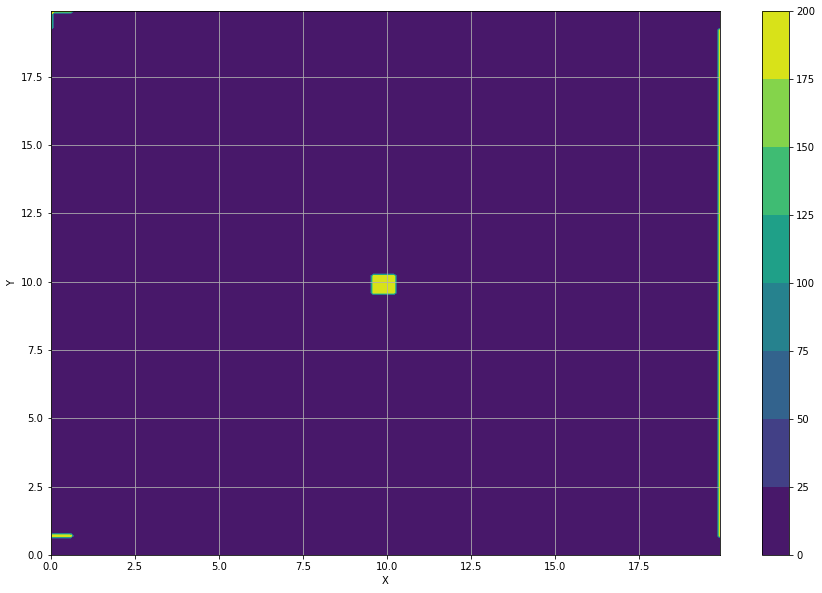

In [8]:
#начальное распределение
plt.figure( figsize= ( 15, 10 ) )
x, y = np.arange( 0, Nx * dx, dx ), np.arange( 0, Ny * dy, dy )

u, lam, rule = StartValue( Nvx, Nvy )

plt.contourf( y, x, u )
plt.xlabel('X')
plt.ylabel('Y')
plt.grid()
plt.colorbar()

plt.show()

999
1999
2999
3999


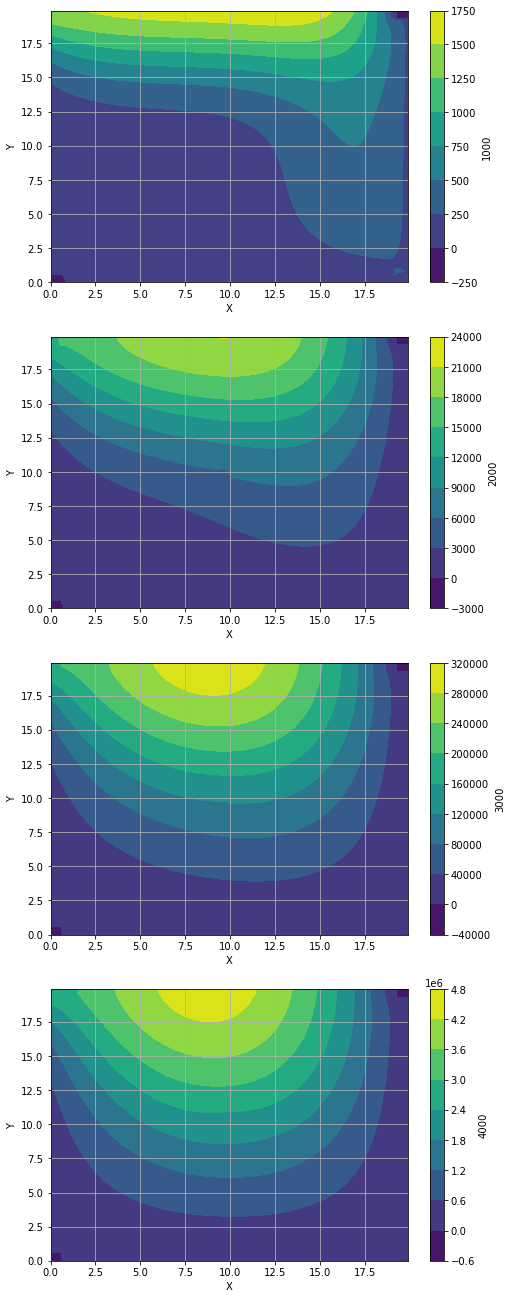

In [11]:
plt.figure( figsize = ( 8, 23 ) )

x, y = np.arange( 0, Nx * dx, dx ), np.arange( 0, Ny * dy, dy )

for Lim in np.arange( 1000, 4001, 1000 ):

    u, lam, rule = StartValue( Nvx, Nvy )

    u = Progon( u, lam, rule, Nvx, Nvy, Lim )

    plt.subplot( 4, 1, int( Lim / 1000 ) )
    plt.contourf( y, x, u )
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid()
    plt.colorbar( label = str(Lim) )

plt.show()